Notebook con entrenamiento del modelo XGBoost con el dataframe con medias ponderadas

Autor: Mateo Turati

Descripción: Obtengo los datos de train, validación y test. Creo dos modelo de XGBoostClassifier usando  dos métodos de ajuste de hiperparámetros y estudio sus resultados

Moficaciones:  
Andrés: He cambiado el codigo para que los modelos usaen la GPU para entrenar

In [29]:
import pandas as pd
import numpy as np
from sklearn.model_selection import  GridSearchCV, RandomizedSearchCV, TimeSeriesSplit
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,log_loss, make_scorer, f1_score, roc_auc_score, precision_score, recall_score
import os
from sklearn.utils.class_weight import compute_class_weight
from xgboost import XGBClassifier
import seaborn as sns
import matplotlib.pyplot as plt


In [30]:
#Leo los df divididos en orden cronológico de forma que los resultados sean lo más reales posibles
ruta_train =  os.path.join("..","..", "data", "P2","train.parquet")
df_train = pd.read_parquet(ruta_train)
df_train.head()

,DATE,Peleador_A,Peleador_B,WINNER,KD_A,KD_B,SIG_STR_A,SIG_STR_B,TD_PORC_A,TD_PORC_B,...,Derrotas_Sub_B,Derrotas_Decision_A,Derrotas_Decision_B,KD_DIFF,SIG_STR_DIFF,TD_DIFF,SUB_ATT_DIFF,REV_DIFF,CTRL_DIFF,YEAR
0,2011-01-22,Melvin Guillard,Evan Dunham,False,0.24,0.00,0.4772,0.3612,0.0000,0.4200,...,0.0,0.0,0.36,0.24,0.1160,-0.475248,-3.16,0.80,-185.76,2011
1,2011-02-26,George Sotiropoulos,Dennis Siver,True,0.24,0.36,0.2548,0.2912,0.4812,0.1600,...,1.0,0.0,2.00,-0.12,-0.0364,0.081182,1.56,0.00,228.72,2011
2,2011-03-19,Ricardo Almeida,Mike Pyle,True,0.00,0.24,0.5056,0.5132,0.4500,0.1368,...,1.0,1.0,0.00,-0.24,-0.0076,0.255163,-1.08,-0.24,238.92,2011
3,2011-03-19,Mirko Filipovic,Brendan Schaub,True,0.24,1.00,0.3820,0.5688,0.0000,0.0000,...,0.0,1.0,0.00,-0.76,-0.1868,0.000000,0.88,0.00,143.08,2011
4,2011-03-19,Dan Miller,Nate Marquardt,True,0.00,0.00,0.3032,0.3912,0.4600,0.2700,...,0.0,3.0,2.36,0.00,-0.0880,0.093856,-0.92,-0.40,188.52,2011


In [31]:
ruta_val = os.path.join("..","..", "data", "P2","validation.parquet")
df_val = pd.read_parquet(ruta_val)
df_val.head()

,DATE,Peleador_A,Peleador_B,WINNER,KD_A,KD_B,SIG_STR_A,SIG_STR_B,TD_PORC_A,TD_PORC_B,...,Derrotas_Sub_B,Derrotas_Decision_A,Derrotas_Decision_B,KD_DIFF,SIG_STR_DIFF,TD_DIFF,SUB_ATT_DIFF,REV_DIFF,CTRL_DIFF,YEAR
0,2022-02-12,King Green,Nasrat Haqparast,False,0.36,0.00,0.5736,0.4404,0.264,0.0000,...,0.0,5.6,1.36,0.36,0.1332,0.298507,0.00,0.40,31.92,2022
1,2022-02-12,Derrick Lewis,Tai Tuivasa,True,0.76,1.00,0.4032,0.6548,0.000,0.0000,...,1.0,0.0,1.00,-0.24,-0.2516,0.000000,0.00,0.00,-46.00,2022
2,2022-02-12,Israel Adesanya,Robert Whittaker,False,0.40,0.64,0.5660,0.4672,0.000,0.2652,...,0.0,0.6,1.00,-0.24,0.0988,-0.243478,0.00,0.72,-167.24,2022
3,2022-02-12,Alexander Hernandez,Renato Moicano,True,0.76,0.00,0.4828,0.5228,0.000,0.6556,...,1.0,0.6,0.00,0.76,-0.0400,-0.528846,-0.76,0.00,-173.80,2022
4,2022-02-12,Jared Cannonier,Derek Brunson,False,0.76,0.00,0.4900,0.5232,0.000,0.5000,...,0.0,2.6,1.00,0.76,-0.0332,-0.445887,-0.60,0.00,-460.76,2022


In [32]:
ruta_test = os.path.join("..","..", "data", "P2","test.parquet")
df_test = pd.read_parquet(ruta_test)
df_test.head()

,DATE,Peleador_A,Peleador_B,WINNER,KD_A,KD_B,SIG_STR_A,SIG_STR_B,TD_PORC_A,TD_PORC_B,...,Derrotas_Sub_B,Derrotas_Decision_A,Derrotas_Decision_B,KD_DIFF,SIG_STR_DIFF,TD_DIFF,SUB_ATT_DIFF,REV_DIFF,CTRL_DIFF,YEAR
0,2023-07-29,Dustin Poirier,Justin Gaethje,True,0.24,0.64,0.5424,0.6192,0.2000,0.1188,...,1.6,1.0,0.0,-0.40,-0.0768,0.049145,0.72,0.00,60.80,2023
1,2023-07-29,Derrick Lewis,Marcos Rogerio de Lima,False,0.00,0.24,0.4064,0.6108,0.2000,0.2312,...,5.0,0.0,1.0,-0.24,-0.2044,0.039576,-0.24,0.00,-136.36,2023
2,2023-08-05,Kyler Phillips,Raoni Barcelos,False,0.24,0.24,0.4712,0.5328,0.4788,0.1520,...,0.0,0.6,2.0,0.00,-0.0616,0.238806,0.72,0.24,28.68,2023
3,2023-08-05,Cory Sandhagen,Rob Font,False,0.00,0.36,0.4108,0.4752,0.1708,0.2000,...,1.0,2.0,3.6,-0.36,-0.0644,-0.011432,0.00,0.40,159.60,2023
4,2023-08-05,Ignacio Bahamondes,Ludovit Klein,True,0.40,0.24,0.5140,0.5616,0.0000,0.2376,...,1.0,1.0,1.0,0.16,-0.0476,-0.230769,0.48,0.00,-267.04,2023


In [33]:
X_train = df_train.drop(columns=["DATE","Peleador_A","Peleador_B","WINNER"])
y_train = df_train["WINNER"]
y_train.value_counts(normalize=True)

WINNER
False    0.565029
True     0.434971
Name: proportion, dtype: float64

In [34]:
X_val = df_val.drop(columns=["DATE","Peleador_A","Peleador_B","WINNER"])
y_val = df_val["WINNER"]
y_val.value_counts(normalize=True)

WINNER
False    0.538288
True     0.461712
Name: proportion, dtype: float64

In [35]:
X_test = df_test.drop(columns=["DATE","Peleador_A","Peleador_B","WINNER"])
y_test = df_test["WINNER"]
y_test.value_counts(normalize=True)

WINNER
False    0.556054
True     0.443946
Name: proportion, dtype: float64

### TRANSFORMACIONES

Para el modelo XGBoost no es necesario realizar transformaciones previas de las variables, como la normalización o estandarización, ya que al ser un modelo basado en árboles de decisión, no se ve afectado por las diferencias en las escalas de los valores ni por la falta de normalidad en la distribución de las variables. Los árboles utilizan divisiones basadas en umbrales y no dependen de operaciones algebraicas sensibles a las magnitudes de las variables.

### SELECCIÓN DE VARIABLES

El modelo XGBoostClassifier no requiere una selección explícita de variables antes del entrenamiento. Al ser un modelo de ensamble de árboles, cada nodo selecciona automáticamente la variable que proporciona la mayor ganancia de información o reducción de impureza. Las variables irrelevantes tienden a ser ignoradas durante las divisiones, por lo que no contribuyen significativamente al modelo final ni añaden ruido. Además, XGBoost incluye regularización, lo que ayuda a reducir aún más el impacto de características poco informativas

### AJUSTE DE HIPERPARÁMETROS

Para buscar una configuración óptima de hiperparámetros he utilizado dos estrategias, GridSearchCV y RandomizedSearchCV. 

En esta estrategia, he definido una cuadrícula (diccionario) con cada hiperparámetro y los posibles valores que pueden tomar. GridSearchCV realiza una búsqueda exhaustiva probando todas las combinaciones posibles de hiperparámetros, evaluando cada modelo mediante validación cruzada. El objetivo es encontrar la combinación que maximice el rendimiento del modelo según el F1-score. Una vez identificado el mejor conjunto de hiperparámetros, procederemos a estudiar el comportamiento del modelo óptimo.

A diferencia de GridSearchCV, RandomizedSearchCV también explora combinaciones de hiperparámetros, pero en lugar de probar todas las combinaciones posibles, selecciona un número fijo de combinaciones al azar. Esto permite explorar un espacio más amplio de hiperparámetros con un menor costo computacional. Al igual que en la búsqueda exhaustiva, las combinaciones son evaluadas mediante validación cruzada, y se selecciona el modelo que optimiza el F1-score.

In [ ]:
def train_xgboost_grid(X_train, y_train, X_val, y_val):
    # Calcular pesos de clase para manejar desbalance de datos
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    scale_pos_weight = class_weights[1] / class_weights[0] if len(class_weights) > 1 else 1
    tscv = TimeSeriesSplit(n_splits=5)
    
    #Activar uso de GPU
    xgb = XGBClassifier(
        random_state=42,
        tree_method='gpu_hist',  # Usar el método 'gpu_hist' para la GPU
        gpu_id=0,                # Usar la primera GPU (puedes cambiar el ID si tienes múltiples GPUs)
        predictor='gpu_predictor', # Utilizar el predictor de GPU
    )
    
    
    # Definir modelo base
    #xgb = XGBClassifier(random_state=42)

    # Cuadrícula de hiperparámetros con y sin ajuste de pesos
    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [10, 15],
        'learning_rate': [0.01, 0.05, 0.1],
        'subsample': [0.7, 1.0],
        'colsample_bytree': [0.7, 1.0],
        'gamma': [0, 0.1, 0.5],
        'min_child_weight': [3, 5],
        'scale_pos_weight': [1, scale_pos_weight],  # 1 = sin ajuste, otro valor = con ajuste
    }

    # Definir la métrica de optimización como el F1-score macro
    f1_scorer = make_scorer(f1_score, average='macro')

    # Búsqueda con validación cruzada
    grid_search = GridSearchCV(
        estimator=xgb,
        param_grid=param_grid,
        scoring=f1_scorer,
        cv=tscv,
        n_jobs=-1,
        verbose=2,
    )

    # Entrenar el modelo
    grid_search.fit(X_train, y_train)

    # Imprimir mejores parámetros
    print("Mejores parámetros:", grid_search.best_params_)

    # Evaluar el mejor modelo en el conjunto de validación
    y_pred = grid_search.best_estimator_.predict(X_val)
    print("Reporte de clasificación:")
    print(classification_report(y_val, y_pred))

    return grid_search.best_estimator_

In [37]:
print("-- Entrenamiento usando ajuste de hiperparámetros con GridSearchCV --")
best_grid = train_xgboost_grid(X_train,y_train,X_val,y_val)

-- Entrenamiento usando ajuste de hiperparámetros con GridSearchCV --
Fitting 5 folds for each of 576 candidates, totalling 2880 fits


KeyboardInterrupt: 

In [ ]:
print("-- Métricas del modelo con hiperparámetros ajustados --")
y_val_pred = best_grid.predict(X_val)
y_val_prob = best_grid.predict_proba(X_val)[:,1]
print("Accuracy:", accuracy_score(y_val, y_val_pred))
f1_val = f1_score(y_val, y_val_pred)
roc_auc_val = roc_auc_score(y_val, y_val_prob)
precision_val = precision_score(y_val, y_val_pred)
recall_val = recall_score(y_val, y_val_pred)
log_loss_val = log_loss(y_val,y_val_prob)
print(f"F1-Score: {f1_val:.4f}")
print(f"AUC-ROC: {roc_auc_val:.4f}")
print(f"Precisión: {precision_val:.4f}")
print(f"Sensibilidad: {recall_val:.4f}")
print(f"Log-loss: {log_loss_val}")

-- Métricas del modelo con hiperparámetros ajustados --
Accuracy: 0.5788288288288288
F1-Score: 0.5337
AUC-ROC: 0.5889
Precisión: 0.5459
Sensibilidad: 0.5220
Log-loss: 0.7666888333499364


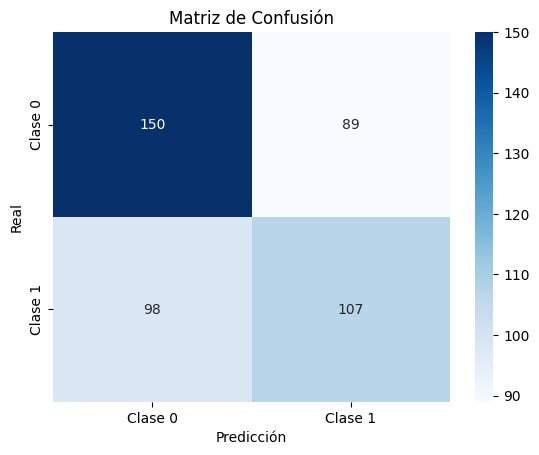

In [ ]:
# Calcular la matriz de confusión
cm = confusion_matrix(y_val, y_val_pred)

# Visualizar la matriz de confusión
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Clase 0', 'Clase 1'], yticklabels=['Clase 0', 'Clase 1'])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión')
plt.show()

In [ ]:
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': best_grid.feature_importances_
}).sort_values(by='Importance', ascending=False)
print(feature_importance)

                Feature  Importance
72             REV_DIFF    0.018137
62        Derrotas_KO_A    0.016828
6             SUB_ATT_A    0.016742
67  Derrotas_Decision_B    0.016284
55              Racha_B    0.016140
..                  ...         ...
27         STR_BODY_B_y    0.010997
4             TD_PORC_A    0.010587
43       STR_GROUND_B_y    0.010494
68              KD_DIFF    0.010477
63        Derrotas_KO_B    0.009132

[75 rows x 2 columns]


In [39]:
def train_xgboost_random(X_train, y_train, X_val, y_val):
    # Calcular pesos de clase para manejar desbalance de datos
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    scale_pos_weight = class_weights[1] / class_weights[0] if len(class_weights) > 1 else 1
    tscv = TimeSeriesSplit(n_splits=5)
    
    #Activar uso de GPU
    xgb = XGBClassifier(
        random_state=42,
        tree_method='gpu_hist',  # Usar el método 'gpu_hist' para la GPU
        gpu_id=0,                # Usar la primera GPU (puedes cambiar el ID si tienes múltiples GPUs)
        predictor='gpu_predictor', # Utilizar el predictor de GPU
    )
    
    # Definir modelo base
    #xgb = XGBClassifier(random_state=42)

    # Distribución de hiperparámetros para búsqueda aleatoria
    param_dist = {
        'n_estimators': np.arange(50, 400, 50),
        'max_depth': np.arange(3, 30, 3),
        'learning_rate': np.linspace(0.01, 0.2, 10),
        'subsample': np.linspace(0.5, 1.0, 6),
        'colsample_bytree': np.linspace(0.5, 1.0, 6),
        'gamma': np.linspace(0, 0.5, 6),
        'min_child_weight': np.arange(1, 10, 2),
        'scale_pos_weight': [1, scale_pos_weight]
    }

    # Definir la métrica de optimización como el F1-score macro
    f1_scorer = make_scorer(f1_score, average='macro')

    # Búsqueda con validación cruzada
    random_search = RandomizedSearchCV(
        estimator=xgb,
        param_distributions=param_dist,
        scoring=f1_scorer,
        n_iter=50,
        cv=tscv,
        n_jobs=-1,
        verbose=2,
        random_state=42
    )

    # Entrenar el modelo
    random_search.fit(X_train, y_train)

    # Imprimir mejores parámetros
    print("Mejores parámetros:", random_search.best_params_)

    # Evaluar el mejor modelo en el conjunto de validación
    y_pred = random_search.best_estimator_.predict(X_val)
    print("Reporte de clasificación:")
    print(classification_report(y_val, y_pred))

    return random_search.best_estimator_

In [ ]:
print("-- Entrenamiento usando ajuste de hiperparámetros con RandomizedSeachCV --")
best_random = train_xgboost_random(X_train,y_train,X_val,y_val)

-- Entrenamiento usando ajuste de hiperparámetros con RandomizedSeachCV --
Fitting 5 folds for each of 50 candidates, totalling 250 fits


c:\Users\andre\OneDrive - Universidad Complutense de Madrid (UCM)\Escritorio\UNIVERSIDAD\2º\2º Cuatrimestre\PD1\c2425-R4\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:37:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:45: `gpu_id` is deprecated since2.0.0, use `device` instead. E.g. device=cpu/cuda/cuda:0
  warnings.warn(smsg, UserWarning)
c:\Users\andre\OneDrive - Universidad Complutense de Madrid (UCM)\Escritorio\UNIVERSIDAD\2º\2º Cuatrimestre\PD1\c2425-R4\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:37:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWa

Mejores parámetros: {'subsample': np.float64(0.6), 'scale_pos_weight': 1, 'n_estimators': np.int64(200), 'min_child_weight': np.int64(5), 'max_depth': np.int64(12), 'learning_rate': np.float64(0.1577777777777778), 'gamma': np.float64(0.1), 'colsample_bytree': np.float64(0.5)}
Reporte de clasificación:
              precision    recall  f1-score   support

       False       0.60      0.64      0.62       239
        True       0.54      0.50      0.52       205

    accuracy                           0.57       444
   macro avg       0.57      0.57      0.57       444
weighted avg       0.57      0.57      0.57       444



c:\Users\andre\OneDrive - Universidad Complutense de Madrid (UCM)\Escritorio\UNIVERSIDAD\2º\2º Cuatrimestre\PD1\c2425-R4\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:37:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\andre\OneDrive - Universidad Complutense de Madrid (UCM)\Escritorio\UNIVERSIDAD\2º\2º Cuatrimestre\PD1\c2425-R4\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:37:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and sl

In [41]:
print("-- Métricas del modelo con hiperparámetros ajustados --")
y_val_pred = best_random.predict(X_val)
y_val_prob = best_random.predict_proba(X_val)[:,1]
print("Accuracy:", accuracy_score(y_val, y_val_pred))
f1_val = f1_score(y_val, y_val_pred)
roc_auc_val = roc_auc_score(y_val, y_val_prob)
precision_val = precision_score(y_val, y_val_pred)
recall_val = recall_score(y_val, y_val_pred)
log_loss_val = log_loss(y_val,y_val_prob)
print(f"F1-Score: {f1_val:.4f}")
print(f"AUC-ROC: {roc_auc_val:.4f}")
print(f"Precisión: {precision_val:.4f}")
print(f"Sensibilidad: {recall_val:.4f}")
print(f"Log-loss: {log_loss_val}")
print(confusion_matrix(y_val, y_val_pred))

-- Métricas del modelo con hiperparámetros ajustados --
Accuracy: 0.5720720720720721
F1-Score: 0.5178
AUC-ROC: 0.5988
Precisión: 0.5397
Sensibilidad: 0.4976
Log-loss: 0.7872044464845986
[[152  87]
 [103 102]]


In [42]:
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': best_random.feature_importances_
}).sort_values(by='Importance', ascending=False)
print(feature_importance)

           Feature  Importance
9            REV_B    0.022658
72        REV_DIFF    0.020435
8            REV_A    0.017677
3        SIG_STR_B    0.017423
54         Racha_A    0.017222
..             ...         ...
1             KD_B    0.010470
48        Record_A    0.010125
56  Victorias_KO_A    0.009695
2        SIG_STR_A    0.009618
22    STR_HEAD_A_y    0.008772

[75 rows x 2 columns]


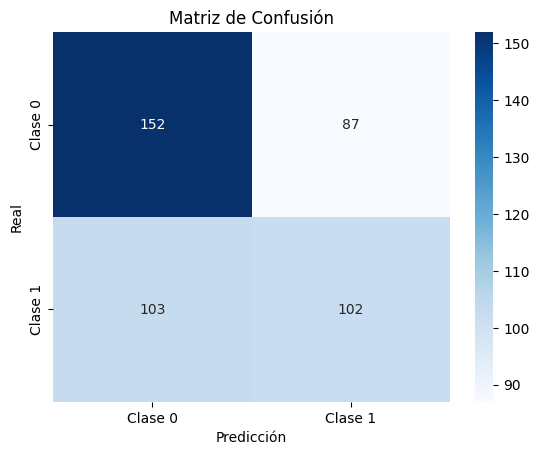

In [43]:
# Calcular la matriz de confusión
cm = confusion_matrix(y_val, y_val_pred)

# Visualizar la matriz de confusión
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Clase 0', 'Clase 1'], yticklabels=['Clase 0', 'Clase 1'])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión')
plt.show()

Tras comparar ambas estrategias, observamos que GridSearchCV tiende a encontrar combinaciones de hiperparámetros más óptimas para mejorar el F1-score, ya que evalúa exhaustivamente todas las posibles combinaciones. Sin embargo, esto conlleva un mayor coste computacional. Por otro lado, RandomizedSearchCV, aunque no explora todas las combinaciones, logra un resultado competitivo con un tiempo de ejecución significativamente menor. En este caso, si bien el modelo obtenido con RandomizedSearchCV muestra un F1-score algo inferior, ha destacado en otras métricas como el accuracy, lo que sugiere que puede ser una alternativa eficiente dependiendo de las restricciones computacionales y los objetivos del modelo.